#### Directories etc

In [22]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Align.Applications import MuscleCommandline
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
import random
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import os
import copy
from Comparative_Analysis import ORF_Functions as orffn
from random import sample
import ete3;

In [19]:
project_dir = 'F:/Project_Data/Project_9'
seq_dir = 'F:/Datasets/Actinobacteria_Ref_Rep_Lev_Complete'
tb_species = 'NC_000962.3' 
num_cores = 16
core_numbers = list(range(1, num_cores+1))
muscle_exe = 'C:/Users/nicho/Muscle/muscle3.8.31_i86win32.exe'

#### Sample of 15 mycobacteria

In [3]:
def create_filename_dict(num_subsets, subset_num, id_list):
    ids = util.chunk_list(id_list, num_subsets, subset_num)
    temp = []
    for id in (ids):
        genome_record = next(SeqIO.parse(seq_dir + '/' + id, "genbank"))
        organism_name = genome_record.annotations['organism']
        temp.append((organism_name, id))
    return temp

species_list = util.list_files(seq_dir)
filename_dict = {}
parallel_output = Parallel(n_jobs=-1)(delayed(create_filename_dict)(num_cores, core_number, species_list) for core_number in core_numbers)
temp = [item for sublist in parallel_output for item in sublist]
for (species_name, filename) in temp:
    filename_dict[species_name] = filename

In [4]:
sample_filenames = ['GCF_000195955.2_ASM19595v2_genomic.gbff', 'GCF_024600175.1_ASM2460017v1_genomic.gbff', 'GCF_010730055.1_ASM1073005v1_genomic.gbff', 'GCF_020616615.1_ASM2061661v1_genomic.gbff', 'GCF_010731535.1_ASM1073153v1_genomic.gbff',
                    'GCF_022370755.1_ASM2237075v1_genomic.gbff', 'GCF_016745295.1_ASM1674529v1_genomic.gbff', 'GCF_000157895.3_ASM15789v2_genomic.gbff', 'GCF_900603025.1_MHAS_genomic.gbff', 'GCF_018363015.1_ASM1836301v1_genomic.gbff',
                    'GCF_019645855.1_ASM1964585v1_genomic.gbff', 'GCF_010727945.1_ASM1072794v1_genomic.gbff', 'GCF_010731895.1_ASM1073189v1_genomic.gbff', 'GCF_900637205.1_50279_G01_genomic.gbff', 'GCF_000184435.1_ASM18443v1_genomic.gbff']
for f in sample_filenames:
    for k, v in filename_dict.items():
        if f==v:
            print(k)

Mycobacterium tuberculosis H37Rv
Mycolicibacterium smegmatis
Mycobacterium shinjukuense
Mycobacterium ulcerans
Mycobacterium lacus
Mycobacterium goodii
Mycobacterium marinum
Mycobacterium kansasii ATCC 12478
Mycolicibacterium hassiacum DSM 44199
Mycolicibacterium neoaurum
Mycobacterium malmoense
Mycobacterium cookii
Mycolicibacterium helvum
Mycolicibacterium chitae
Mycolicibacterium gilvum Spyr1


In [5]:
organism_name_dict = {}
protein_dict = {}
sample_info = []
for filename in tqdm(sample_filenames):
    genome_record = next(SeqIO.parse(seq_dir + '/' + filename, "genbank"))
    organism_name = genome_record.annotations['organism']
    accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
    organism_name_dict[accession_ver] = organism_name
    for feature in genome_record.features:
        a = feature.qualifiers
        if feature.type == 'CDS':
            if a.get("protein_id") != None and a.get("locus_tag")!= None and a.get("translation")!= None:

                locus_tag = a.get("locus_tag")[0]
                protein_id = a.get("protein_id")[0]
                translation = a.get("translation")[0]
                sample_info.append([organism_name, accession_ver, int(feature.location.start), int(feature.location.end), int(feature.location.strand), locus_tag, protein_id, translation])
                protein_dict[accession_ver+'@'+protein_id] = translation

100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


In [46]:
# Full sample
util.produce_fasta_file([[x[1]+'@'+x[6], x[7]] for x in sample_info], project_dir + '/full_sample_proteins.fasta')
# Tb only
util.produce_fasta_file([[x[1]+'@'+x[6], x[7]] for x in sample_info if 'H37Rv' in x[0]], project_dir + '/H37Rv_proteins.fasta')

100%|██████████| 3906/3906 [00:00<00:00, 49347.43it/s]


#### Produce FASTA file with CDS candidates

In [47]:
blastfn.build_blast_db(project_dir, 'full_sample_proteins.fasta', 'full_sample_proteins', 'F:/Datasets/BLAST/full_sample_proteins')

In [48]:
blastfn.build_blast_db(project_dir, 'H37Rv_proteins.fasta', 'H37Rv_proteins', 'F:/Datasets/BLAST/H37Rv_proteins')

In [49]:
blastfn.run_blastp('F:/Datasets/BLAST/full_sample_proteins', 'H37Rv_proteins.fasta', 'full_sample_proteins', e_value = 1e-5)

In [50]:
blastfn.run_blastp('F:/Datasets/BLAST/H37Rv_proteins', 'full_sample_proteins.fasta', 'H37Rv_proteins', e_value = 1e-5)

In [6]:
H37Rv_v_full_sample_blast_df = blastfn.process_blast_output('F:/Datasets/BLAST/full_sample_proteins/hits.csv',project_dir + '/H37Rv_v_full_sample_blast_results.pkl' ,organism_name_dict, top_hit_only = True)
full_sample_v_H37Rv_blast_df = blastfn.process_blast_output('F:/Datasets/BLAST/H37Rv_proteins/hits.csv',project_dir + '/full_sample_v_H37Rv_blast_results.pkl' ,organism_name_dict, top_hit_only = True)
rbh_df = blastfn.keep_reciprocal_best_hits(H37Rv_v_full_sample_blast_df, full_sample_v_H37Rv_blast_df , project_dir + 'rbh_df.pkl')
rbh_df.to_csv(project_dir + '/rbh.csv')

In [7]:
ortholog_count_dict = {}
for i, r in rbh_df.iterrows():
    if r['query_ref'] in ortholog_count_dict:
        ortholog_count_dict[r['query_ref']] +=1
    else:
        ortholog_count_dict[r['query_ref']] =1
full_orthologs = []
for k, v in ortholog_count_dict.items():
    if v == len(sample_filenames):
        full_orthologs.append(k)

In [74]:
samp = random.sample(full_orthologs, 200)

In [75]:
ortholog_sequences = []
for query_ref in tqdm(samp):
    seq = []
    for i,r in rbh_df.iterrows():
        if r['query_ref'] == query_ref:
            seq.append([r['target_ref'], protein_dict[r['target_ref']]])
    ortholog_sequences.append(seq)

100%|██████████| 200/200 [02:43<00:00,  1.22it/s]


In [ ]:
concatenated_dict = {}
for seqset in ortholog_sequences:
    util.produce_fasta_file(seqset, project_dir + '/temp.fasta')
    cline = MuscleCommandline(muscle_exe, input= project_dir + '/temp.fasta', out=project_dir + '/align.fasta')
    try:
        stdout, stderr = cline()
    except Exception as e:
        pass
    a = util.read_fasta_to_array(project_dir + '/align.fasta')
    b = list(zip(a[0],a[1]))
    for info in b:
        species = info[0].split('@')[0]
        if species in concatenated_dict:
            concatenated_dict[species] += info[1]
        else:
            concatenated_dict[species] = info[1]
outfile = []
for k, v in concatenated_dict.items():
    outfile.append([k, v])
util.produce_fasta_file(outfile, project_dir + '/concatenated_alignments.faa')
util.convert_sequence_file_format(project_dir + '/concatenated_alignments.faa', project_dir + '/concatenated_alignments.phy', input_file_format = "fasta", output_file_format = "phylip")

In [84]:
distances_df = pd.read_excel(project_dir +'/mega_distances.xlsx')

In [87]:
distance_dict = {}
distance_dict[tb_species] = 0.0
for i, r in distances_df.iterrows():
    if r[tb_species] > 0:
        distance_dict[r[0]] = r[tb_species]

In [88]:
distance_dict

{'NC_000962.3': 0.0,
 'NZ_CP058277.1': 0.250638393352535,
 'NZ_CP085200.1': 0.307956335938722,
 'NC_022663.1': 0.231420637861121,
 'NZ_AP022575.1': 0.24099051895268,
 'NZ_AP022569.1': 0.400377886701493,
 'NZ_AP022581.1': 0.210380308606155,
 'NZ_CP080999.1': 0.265196545281372,
 'NZ_LR026975.1': 0.612421969608002,
 'NZ_AP022596.1': 0.506920329021992,
 'NZ_CP092364.1': 0.652851130510998,
 'NZ_CP102342.1': 0.662860911565298,
 'NC_014814.1': 0.671022699484172,
 'NZ_CP074376.1': 0.689580853941057,
 'NZ_LR134355.1': 0.55003222094137}

,query_ref,target_ref,query_length,subject_length,percent_identical_matches,alignment_length,number_mismatches,number_of_gap_openings,query_start_alignment,query_end_alignment,target_start_alignment,target_end_alignment,e_value,bit_score,query_species,target_species,query_species_name,target_species_name,species_count,reciprocal_best_hit
0,NC_000962.3@NP_214515.1,NC_000962.3@NP_214515.1,507,507,100.000,507,0,0,1,507,1,507,0.0,1039.0,NC_000962.3,NC_000962.3,Mycobacterium tuberculosis H37Rv,Mycobacterium tuberculosis H37Rv,15,Y
10,NC_000962.3@NP_214515.1,NC_014814.1@WP_041788299.1,507,490,78.304,507,93,3,1,507,1,490,0.0,801.0,NC_000962.3,NC_014814.1,Mycobacterium tuberculosis H37Rv,Mycolicibacterium gilvum Spyr1,15,Y
5,NC_000962.3@NP_214515.1,NC_022663.1@WP_036395213.1,507,514,86.576,514,62,3,1,507,1,514,0.0,870.0,NC_000962.3,NC_022663.1,Mycobacterium tuberculosis H37Rv,Mycobacterium kansasii ATCC 12478,15,Y
7,NC_000962.3@NP_214515.1,NZ_AP022569.1@WP_163777397.1,507,500,86.220,508,61,3,1,507,1,500,0.0,853.0,NC_000962.3,NZ_AP022569.1,Mycobacterium tuberculosis H37Rv,Mycobacterium cookii,15,Y
1,NC_000962.3@NP_214515.1,NZ_AP022575.1@WP_083049377.1,507,506,86.719,512,57,3,1,507,1,506,0.0,891.0,NC_000962.3,NZ_AP022575.1,Mycobacterium tuberculosis H37Rv,Mycobacterium shinjukuense,15,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322364,NC_000962.3@YP_178027.1,NZ_CP085200.1@WP_240168643.1,406,406,90.640,406,38,0,1,406,1,406,0.0,750.0,NC_000962.3,NZ_CP085200.1,Mycobacterium tuberculosis H37Rv,Mycobacterium ulcerans,15,Y
322367,NC_000962.3@YP_178027.1,NZ_CP092364.1@WP_073677688.1,406,396,86.735,392,52,0,11,402,3,394,0.0,690.0,NC_000962.3,NZ_CP092364.1,Mycobacterium tuberculosis H37Rv,Mycobacterium goodii,15,Y
322366,NC_000962.3@YP_178027.1,NZ_CP102342.1@WP_003898354.1,406,396,86.990,392,51,0,11,402,3,394,0.0,691.0,NC_000962.3,NZ_CP102342.1,Mycobacterium tuberculosis H37Rv,Mycolicibacterium smegmatis,15,Y
322371,NC_000962.3@YP_178027.1,NZ_LR026975.1@WP_005623073.1,406,418,84.319,389,61,0,11,399,3,391,0.0,672.0,NC_000962.3,NZ_LR026975.1,Mycobacterium tuberculosis H37Rv,Mycolicibacterium hassiacum DSM 44199,15,Y


In [90]:
full_orthologs[0]

'NC_000962.3@NP_214515.1'

<AxesSubplot:xlabel='distance', ylabel='score'>

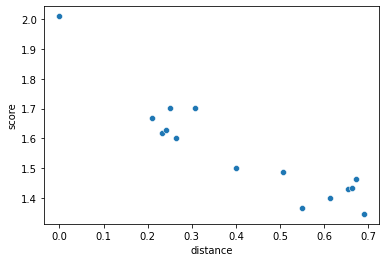

In [108]:
results = []
for ortholog in full_orthologs[176:177]:
    for i, r in rbh_df.iterrows():
        if r['query_ref'] == ortholog:
            results.append([distance_dict[r['target_species']], r['bit_score']/r['query_length'], ortholog])
results_df = pd.DataFrame(results, columns = ['distance', 'score', 'ortholog_ref'])
sns.scatterplot(data=results_df, x="distance", y="score")

<AxesSubplot:xlabel='score', ylabel='evalue'>

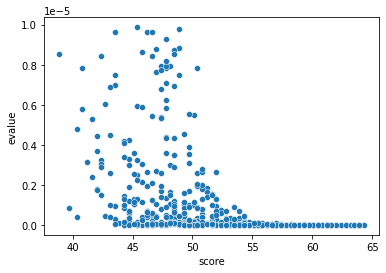

In [113]:
results = []
for i, r in rbh_df.iterrows():
    if r['e_value'] > 1e-10:
        results.append([r['bit_score'], r['e_value']])
results_df = pd.DataFrame(results, columns = ['score', 'evalue'])
sns.scatterplot(data=results_df, x="score", y="evalue")

In [109]:
rbh_df

,query_ref,target_ref,query_length,subject_length,percent_identical_matches,alignment_length,number_mismatches,number_of_gap_openings,query_start_alignment,query_end_alignment,target_start_alignment,target_end_alignment,e_value,bit_score,query_species,target_species,query_species_name,target_species_name,species_count,reciprocal_best_hit
0,NC_000962.3@NP_214515.1,NC_000962.3@NP_214515.1,507,507,100.000,507,0,0,1,507,1,507,0.0,1039.0,NC_000962.3,NC_000962.3,Mycobacterium tuberculosis H37Rv,Mycobacterium tuberculosis H37Rv,15,Y
10,NC_000962.3@NP_214515.1,NC_014814.1@WP_041788299.1,507,490,78.304,507,93,3,1,507,1,490,0.0,801.0,NC_000962.3,NC_014814.1,Mycobacterium tuberculosis H37Rv,Mycolicibacterium gilvum Spyr1,15,Y
5,NC_000962.3@NP_214515.1,NC_022663.1@WP_036395213.1,507,514,86.576,514,62,3,1,507,1,514,0.0,870.0,NC_000962.3,NC_022663.1,Mycobacterium tuberculosis H37Rv,Mycobacterium kansasii ATCC 12478,15,Y
7,NC_000962.3@NP_214515.1,NZ_AP022569.1@WP_163777397.1,507,500,86.220,508,61,3,1,507,1,500,0.0,853.0,NC_000962.3,NZ_AP022569.1,Mycobacterium tuberculosis H37Rv,Mycobacterium cookii,15,Y
1,NC_000962.3@NP_214515.1,NZ_AP022575.1@WP_083049377.1,507,506,86.719,512,57,3,1,507,1,506,0.0,891.0,NC_000962.3,NZ_AP022575.1,Mycobacterium tuberculosis H37Rv,Mycobacterium shinjukuense,15,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322364,NC_000962.3@YP_178027.1,NZ_CP085200.1@WP_240168643.1,406,406,90.640,406,38,0,1,406,1,406,0.0,750.0,NC_000962.3,NZ_CP085200.1,Mycobacterium tuberculosis H37Rv,Mycobacterium ulcerans,15,Y
322367,NC_000962.3@YP_178027.1,NZ_CP092364.1@WP_073677688.1,406,396,86.735,392,52,0,11,402,3,394,0.0,690.0,NC_000962.3,NZ_CP092364.1,Mycobacterium tuberculosis H37Rv,Mycobacterium goodii,15,Y
322366,NC_000962.3@YP_178027.1,NZ_CP102342.1@WP_003898354.1,406,396,86.990,392,51,0,11,402,3,394,0.0,691.0,NC_000962.3,NZ_CP102342.1,Mycobacterium tuberculosis H37Rv,Mycolicibacterium smegmatis,15,Y
322371,NC_000962.3@YP_178027.1,NZ_LR026975.1@WP_005623073.1,406,418,84.319,389,61,0,11,399,3,391,0.0,672.0,NC_000962.3,NZ_LR026975.1,Mycobacterium tuberculosis H37Rv,Mycolicibacterium hassiacum DSM 44199,15,Y
